<a href="https://colab.research.google.com/github/Kahkashan2708/Pytorch-code/blob/main/QnA_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question-Answering Using RNN**
---

## RNN Architecture

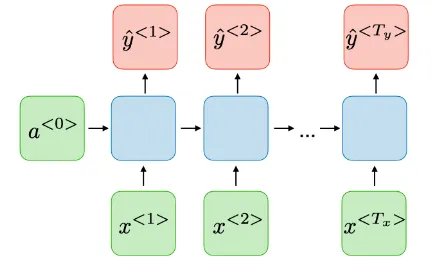

In [28]:
import pandas as pd
df = pd.read_csv('/content/100_Unique_QA_Dataset.csv')
df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


## Tokenization

In [2]:
# tokenize
def tokenize(text):
  text = text.lower()
  text = text.replace('?','')
  text = text.replace("'","")
  return text.split()

In [3]:
tokenize('What is the capital of France?')

['what', 'is', 'the', 'capital', 'of', 'france']

In [4]:
# vocab
vocab = {'<UNK>':0}

In [5]:
def build_vocab(row):
  tokenized_question = tokenize(row['question'])
  tokenized_answer = tokenize(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)

In [6]:
df.apply(build_vocab, axis=1)

,0
0,None
1,None
2,None
3,None
4,None
...,...
85,None
86,None
87,None
88,None


In [7]:
len(vocab)

324

In [8]:
# convert words to numerical indices
def text_to_indices(text, vocab):

  indexed_text = []

  for token in tokenize(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [9]:
text_to_indices("What is campusx", vocab)

[1, 2, 0]

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [11]:
class QADataset(Dataset):
  def __init__(self, df, vocab):
    self.df = df
    self.vocab = vocab

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):

    numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
    numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)
    return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [12]:
dataset = QADataset(df, vocab)

In [13]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [14]:
for question, answer in dataloader:
  print(question, answer[0])

tensor([[  1,   2,   3, 146,  86,  19, 192, 193]]) tensor([194])
tensor([[ 42, 107,   2, 108,  19, 109]]) tensor([110])
tensor([[ 42, 137,   2, 138,  39, 139]]) tensor([53])
tensor([[ 42,  86,  87, 241, 242,  19,  39, 243]]) tensor([244])
tensor([[ 1,  2,  3,  4,  5, 73]]) tensor([74])
tensor([[  1,   2,   3,   4,   5, 279]]) tensor([280])
tensor([[10,  2,  3, 66,  5, 67]]) tensor([68])
tensor([[  1,   2,   3, 212,   5,  14, 213, 214]]) tensor([215])
tensor([[  1,   2,   3, 234,   5, 235]]) tensor([131])
tensor([[  1,   2,   3, 163, 164, 165,  83,  84]]) tensor([166])
tensor([[ 1,  2,  3, 17, 18, 19, 20, 21, 22]]) tensor([23])
tensor([[ 78,  79, 129,  81,  19,   3,  21,  22]]) tensor([36])
tensor([[ 42, 216, 118, 217, 218,  19,  14, 219,  43]]) tensor([220])
tensor([[ 42, 255,   2, 256,  83, 257, 258]]) tensor([259])
tensor([[  1,   2,   3,  17, 115,  83,  84]]) tensor([116])
tensor([[1, 2, 3, 4, 5, 6]]) tensor([7])
tensor([[  1,   2,   3,  37,  38,  39, 161]]) tensor([162])
tensor([[ 

In [16]:
class SimpleRNN(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim=50)
    self.rnn = nn.RNN(50, 64, batch_first=True)
    self.fc = nn.Linear(64, vocab_size)

  def forward(self, question):
    embedded_question = self.embedding(question)
    hidden, final = self.rnn(embedded_question)
    output = self.fc(final.squeeze(0))

    return output

In [17]:
learning_rate = 0.001
epochs = 20

In [18]:
model = SimpleRNN(len(vocab))

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [21]:
# Training loop
for epoch in range(epochs):
  total_loss = 0

  for question, answer in dataloader:
    optimizer.zero_grad()
    # forward pass
    output = model(question)
    # loss -> output shape (1,324) - (1)
    loss = criterion(output, answer[0])
    # gradients
    loss.backward()
    # update
    optimizer.step()
    total_loss = total_loss + loss.item()
  total_loss = (total_loss)/324
  print(f"Epoch: {epoch+1}, Loss: {total_loss:4f}")

Epoch: 1, Loss: 0.032116
Epoch: 2, Loss: 0.028051
Epoch: 3, Loss: 0.024828
Epoch: 4, Loss: 0.022174
Epoch: 5, Loss: 0.019657
Epoch: 6, Loss: 0.017859
Epoch: 7, Loss: 0.016026
Epoch: 8, Loss: 0.014725
Epoch: 9, Loss: 0.013188
Epoch: 10, Loss: 0.012009
Epoch: 11, Loss: 0.011054
Epoch: 12, Loss: 0.010153
Epoch: 13, Loss: 0.009375
Epoch: 14, Loss: 0.008662
Epoch: 15, Loss: 0.008005
Epoch: 16, Loss: 0.007434
Epoch: 17, Loss: 0.006918
Epoch: 18, Loss: 0.006424
Epoch: 19, Loss: 0.006009
Epoch: 20, Loss: 0.005599


## Predict Function

In [22]:
def predict(model, question, threshold=0.5):

  # convert question to numbers
  numerical_question = text_to_indices(question, vocab)
  # tensor
  question_tensor = torch.tensor(numerical_question).unsqueeze(0)
  # send to model
  output = model(question_tensor)
  # convert logits to probs
  probs = torch.nn.functional.softmax(output, dim=1)
  # find index of max prob
  value, index = torch.max(probs, dim=1)

  if value < threshold:
    print("I don't know")
  print(list(vocab.keys())[index])

In [23]:
predict(model, "What is the largest planet in our solar system?")

jupiter


In [24]:
predict(model, "What is the capital of Germany?")

berlin


In [27]:
predict(model, "Who directed the movie 'Titanic'?")

jamescameron


In [29]:
predict(model, "What is the smallest prime number?")

2
